# Sentiment Analysis
### Imports

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import os
from torch.nn.functional import softmax
from dotenv import load_dotenv
import gc


In [30]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()

171

### Load checkpoint

In [31]:
load_dotenv()

hf_token = os.getenv("HF_TOKEN")

# Load Hugging Face model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

### Load Data

In [97]:
# Load the CSV
df = pd.read_csv("reddit_data/apple_2025-04-11.csv")

### Batch compute sentiment scores

In [98]:
import torch
from torch.nn.functional import softmax
from tqdm import tqdm

# Prepare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
texts = df["text"].astype(str).tolist()

# Storage
logits_neg = []
logits_pos = []
preds = []

# Batch size (adjust based on your GPU)
batch_size = 32

for i in tqdm(range(0, len(texts), batch_size), desc="Running batches"):
    batch_texts = texts[i:i + batch_size]
    inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=100).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        batch_logits = outputs.logits
        batch_probs = softmax(batch_logits, dim=1)
        batch_preds = torch.argmax(batch_probs, dim=1)

        logits_neg.extend(batch_logits[:, 0].cpu().tolist())
        logits_pos.extend(batch_logits[:, 1].cpu().tolist())
        preds.extend(batch_preds.cpu().tolist())

# Attach results to DataFrame
df["logit_negative"] = logits_neg
df["logit_positive"] = logits_pos
df["predicted_sentiment"] = preds
df["predicted_label"] = df["predicted_sentiment"].replace({0: "negative", 1: "positive"})

Running batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 37.42it/s]


In [99]:
df["date"] =  pd.to_datetime(df["created_at"],utc=True).dt.date
df["year_month"] = pd.to_datetime(df["created_at"],utc=True).dt.strftime("%Y-%m")

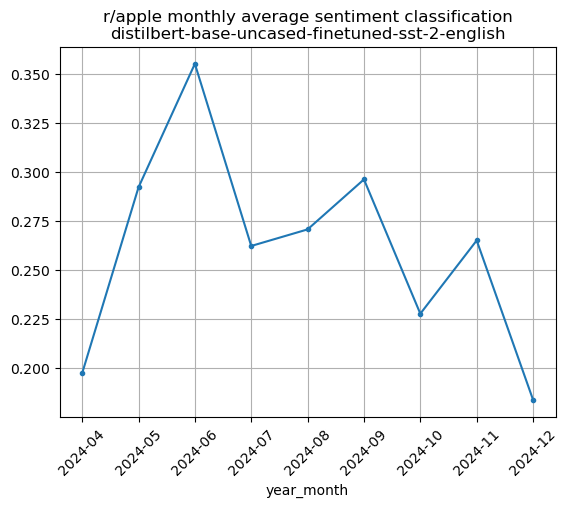

In [100]:
ax = df.groupby('year_month').agg({
    'predicted_sentiment': ['mean','std'],
    'score': 'sum',
    'text': lambda x: len(x)
}).iloc[:,0].plot(marker='.');
ax.tick_params(axis='x', labelrotation=45);
ax.grid();
ax.set_title(f"r/{df.subreddit.max()} monthly average sentiment classification\n{model_name}");